In [1]:
def spotifyID(link):
    link = link.replace("https://open.spotify.com/playlist/","spotify:playlist:")
    return(link[:-20])


In [2]:
import json
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials

client_id = 'client_id' #insert your client id
client_secret = 'client_secret' # insert your client secret id here

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)


link = "https://open.spotify.com/playlist/xxxxxxxxx"

results = sp.playlist(spotifyID(link))


In [3]:
playlist = results['name']
owner = results['owner']['display_name']

ids=[]

for item in results['tracks']['items']:
        track = item['track']['id']
        ids.append(track)
        
song_meta={'id':[],'album':[], 'name':[], 
           'artist':[],'explicit':[],'popularity':[]}

for song_id in ids:
    # get song's meta data
    meta = sp.track(song_id)
    
    # song id
    song_meta['id'].append(song_id)

    # album name
    album=meta['album']['name']
    song_meta['album']+=[album]

    # song name
    song=meta['name']
    song_meta['name']+=[song]
    
    # artists name
    s = ', '
    artist=s.join([singer_name['name'] for singer_name in meta['artists']])
    song_meta['artist']+=[artist]
    
    # explicit: lyrics could be considered offensive or unsuitable for children
    explicit=meta['explicit']
    song_meta['explicit'].append(explicit)
    
    # song popularity
    popularity=meta['popularity']
    song_meta['popularity'].append(popularity)

song_meta_df=pd.DataFrame.from_dict(song_meta)

# check the song feature
features = sp.audio_features(song_meta['id'])
# change dictionary to dataframe
features_df=pd.DataFrame.from_dict(features)

# convert milliseconds to mins
# duration_ms: The duration of the track in milliseconds.
# 1 minute = 60 seconds = 60 × 1000 milliseconds = 60,000 ms
features_df['duration_ms']=features_df['duration_ms']/60000

# combine two dataframe
final_df=song_meta_df.merge(features_df)

In [8]:
music_feature = features_df[['danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms']]
music_feature

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.349,0.753,-6.194,0.0383,0.001620,0.592000,0.4150,0.107,118.670,4.350300
1,0.468,0.889,-3.404,0.0828,0.000907,0.000000,0.1100,0.255,171.014,3.368417
2,0.601,0.723,-4.364,0.0384,0.000347,0.001100,0.3460,0.581,114.991,3.948883
3,0.519,0.960,-5.406,0.0578,0.000242,0.000134,0.6460,0.196,130.015,3.692300
4,0.626,0.792,-2.734,0.0721,0.000126,0.022000,0.4380,0.433,133.212,3.143333
...,...,...,...,...,...,...,...,...,...,...
66,0.325,0.956,-3.275,0.1470,0.000050,0.018700,0.3340,0.429,185.922,2.710350
67,0.509,0.448,-7.552,0.0357,0.007130,0.013700,0.2440,0.221,156.909,3.843550
68,0.558,0.902,-4.521,0.0451,0.000282,0.002370,0.1010,0.570,160.065,3.256517
69,0.572,0.852,-4.712,0.0322,0.001050,0.000000,0.0844,0.378,129.969,3.606850


In [9]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
music_feature.loc[:]=min_max_scaler.fit_transform(music_feature.loc[:])

/home/hossein/python-environments/spotify/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/hossein/python-environments/spotify/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


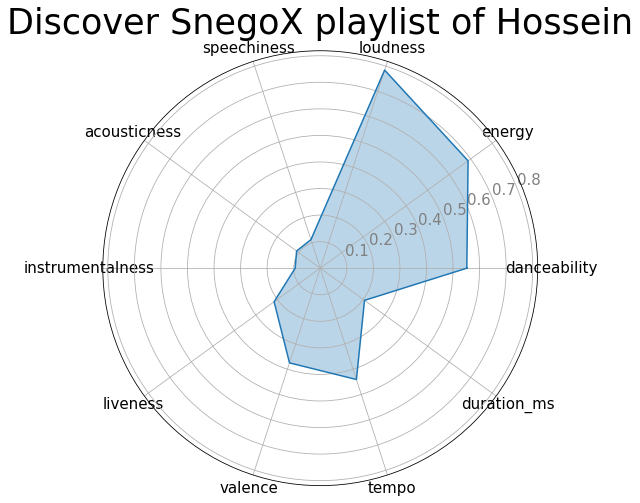

In [10]:
import matplotlib.pyplot as plt
import numpy as np
# plot size
fig=plt.figure(figsize=(12,8))

categories=list(music_feature.columns)
N=len(categories)
value=list(music_feature.mean())
value+=value[:1]
angles=[n / float(N) * 2 * np.pi for n in range(N)]
angles+=angles[:1]
plt.polar(angles, value)
plt.fill(angles,value,alpha=0.3)

plt.title('Discover {} playlist of {}'.format(playlist,owner), size=35)

plt.xticks(angles[:-1],categories, size=15)
plt.yticks(color='grey',size=15)
plt.show()
